# 1 - Raw Data Visualisation

<img src="Images/grideye_mounting.png" alt="grideye camera view" width="250" height="250" align="left">
<img src="Images/sensor_parts.png" alt="layout" width="200" height="200" align="right"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; For some some context here is our setup.   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The left image is our [Panasonic Grid-EYE Evaluation Kit](https://eu.industrial.panasonic.com/grideye-evalkit) connected to a   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Raspberry Pi (for storing data locally)<sup>1</sup>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The Grid-EYE is an 8×8 thermal camera. Just to make that clear, that’s 64 pixels, 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; not megapixels! This super low resolution allows us to stick in sensitive places  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (say a bathroom) without privacy fears  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The right image is the range of view of our Grid-EYE, which is pointing right at   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; the back of a urinal user.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; It's placed for wall-to-wall, floor-to-ceiling viewing.






___
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<sup>1</sup> <span style=" font-size:0.8em;">See our [Medium post]() for more info</span>

In [2]:
import pandas as pd
import numpy as np

import csv
from tqdm import tqdm_notebook,tnrange,tqdm_pandas,tqdm
tqdm.pandas()

import os
import cPickle as pickle

import datetime as dt


import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
#notify if cell is finished for cells taking longer than 30 seconds
%autonotify -a 30

<IPython.core.display.Javascript object>

### Path to your urinal-data-28-nov_clean _pickle_ file

In [3]:
pickle_full = "Data Files/urinal-data-28-nov_clean.p"

### Path to your urinal-data-28-nov_clean [_CSV_](https://drive.google.com/uc?export=download&confirm=AC5G&id=1RaE3ckLvBRfzKpnq61KSp-kZp98Ia7yz) file

In [4]:
csv_full = "Data Files/urinal-data-28-nov_clean.csv"
if not os.path.isfile(csv_full):
    print("Please Download the csv file (link above)")

## Clean Up Our Raw data for analyis
 
read in pickle or read csv, cleanup, and create pickle

In [5]:
  
if os.path.isfile(pickle_full):
    print("loading pickle")
    df = pd.read_pickle(pickle_full)
   
else:
    print("creating pickle...")
    print("this will take some time...")
    df = pd.read_csv(csv_full)
    df.columns = ["time"]+["P"+str(x) for x in range(64)]
    
    # remove dirty data
    df = df[[(x[:2] != "TT") for x in df["time"]]]
    df = df[[x[16:18] != ":S" for x in df["time"]]]
        
    # drop indexes where camera had fallen down/face was in camera
    df = df.drop(range(0,97710+14234), axis=0) #drop row
    df["time"] = df["time"].progress_apply(pd.to_datetime,format="%a %b %d %H:%M:%S %Y") + dt.timedelta(hours=10)
    df = df.set_index('time')
    
    #flip image
    cols = []
    for y in range(7,-1,-1):
            for x in range(8):
                cols.append(x*8+y)
            
    cols = ["P"+str(x) for x in cols] 
    df = df.reindex(columns=cols)
   
    # reset column names
    df.columns = ["P"+str(x) for x in range(64)]
        
    df.to_pickle(pickle_full)


loading pickle


### Raw Data
Our dataframe is a composed of rows containing the 64 (8x8) thermal sensor Pixels of the Grid-EYE.    
with column P0 - P7 the top line of pixels, and P56 - P63 the bottom line.  
Each value therefore corresponds to a temperature in <sup>o</sup>C  
Each row is timestamped

In [6]:
df.sample(5)

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P54,P55,P56,P57,P58,P59,P60,P61,P62,P63
time,,,,,,,,,,,,,,,,,,,,,
2017-11-26 03:11:58,21.25,24.00,23.25,21.75,23.50,23.25,23.75,22.75,22.25,23.50,...,23.50,23.25,21.75,23.50,22.75,22.75,23.75,24.00,22.75,23.25
2017-11-24 14:47:57,22.25,23.25,21.25,22.50,23.25,23.25,22.75,23.75,22.75,23.00,...,23.00,23.00,22.50,23.25,23.25,23.50,22.50,24.25,22.25,24.00
2017-11-26 17:29:07,23.25,22.25,23.50,22.75,24.25,23.75,24.75,23.50,22.75,24.00,...,23.75,23.75,22.25,23.75,24.25,21.75,24.00,24.25,22.75,22.00
2017-11-24 07:34:38,22.25,23.00,21.00,22.25,22.75,23.25,23.25,22.25,21.25,22.75,...,22.75,21.75,22.25,23.50,23.25,22.25,23.50,23.50,22.50,22.50
2017-11-24 05:37:47,22.25,22.50,22.50,21.75,22.50,23.50,22.75,24.00,21.50,22.25,...,21.75,22.75,21.50,22.50,22.50,22.75,23.50,23.25,23.00,21.00


### Urinal Section Visualisation
Below you can see the the Urinal positions (_Left_, _Middle_, and _Right_) with respect to the camera.  
The back of a head sits around row 3 or 4 (depending on height).    
Also annotated is the _Empty Space_,   
since no-one in our office is taller than 7 foot we'll never have a visitor in this region.

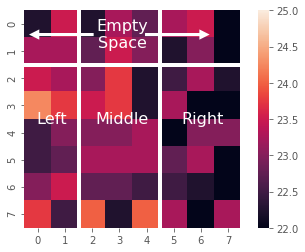

In [23]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


frame = np.array(df.iloc[0]).reshape(8,8).astype('float')

ax = sns.heatmap(frame, vmin=22, vmax=25,square=True)
ax.vlines([2, 5, 8], *ax.get_xlim(),color='white', linewidth=4)
ax.hlines([2], *ax.get_xlim(),color='white', linewidth=4)
ax.text(0.125, 0.5,'Left', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,
       color='white',size=16);
ax.text(0.45, 0.5,'Middle', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,
       color='white',size=16);

ax.text(0.82, 0.5,'Right', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,
       color='white',size=16);

ax.text(0.45, 0.89,'Empty\nSpace', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,
       color='white',size=16);
ax.arrow(2.5, 0.89, -2, 0, head_width=0.2, head_length=0.2, fc='w', ec='w',linewidth=3)
ax.arrow(4.5, 0.89, 2, 0, head_width=0.2, head_length=0.2, fc='w', ec='w',linewidth=3)

plt.savefig('Images/layout_sections.png', dpi=600)

## Visualise Our Data!
We have an 8x8 grid of thermal pixels: Seaborns heatmap is perfect here.


Below we'll look at a typical instance of a person walking in and out of our area of interest.  
This particular person visited the left urinal at 4 pm on a Friday.  
### Animation of a Walk in
Here you can see a person walking in to use the left Urinal.

In [8]:
startIn = df.index.searchsorted(dt.datetime(2017, 11, 24, 15, 59,37,0))
endIn = df.index.searchsorted(dt.datetime(2017, 11, 24, 15,59,41,0))

In [9]:
framesIn = []
for row in df.iloc[startIn:endIn].iterrows():
        framesIn.append(np.array(row[1]).reshape(8,8).astype('float'))


In [ ]:
plt.style.use('ggplot')
plt.rcParams['animation.writer'] = 'ffmpeg'
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib notebook
fig, ax = plt.subplots()

def init():
    plt.clf();
    sns.heatmap(np.zeros((8, 8)),vmin=22,vmax=25,square=True)
    plt.clf();

def animate(i):
    plt.clf();
    data = framesIn[i]
    sns.heatmap(data, vmin=22,vmax=25,square=True)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(framesIn),interval=100,repeat=True)
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

### Animation of a Walk Out

In [11]:
startOut = df.index.searchsorted(dt.datetime(2017, 11, 24, 16,0,3,0))
endOut = df.index.searchsorted(dt.datetime(2017, 11, 24, 16,0,7,0))

In [12]:
framesOut = []
for row in df.iloc[startOut:endOut].iterrows():
        framesOut.append(np.array(row[1]).reshape(8,8).astype('float'))



In [22]:
plt.rcParams['animation.writer'] = 'ffmpeg'
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()
def init():
    plt.clf()
    sns.heatmap(np.zeros((8, 8)),vmin=22,vmax=25,square=True);
    plt.clf()

def animate(i):
    plt.clf()
    data = framesOut[i]
    sns.heatmap(data, vmin=22,vmax=25,square=True)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(framesOut),interval=100,repeat=True)
HTML(anim.to_html5_video())

You might have noticed how noisy the data is.
There are two main reasons for this.
1. The accuracy and precision of the Grideye is low (&pm;2.5&deg;C, and &pm;0.25&deg;C respectively) <sup>[1](https://industrial.panasonic.com/cdbs/www-data/pdf/ADI8000/ADI8000C53.pdf)</sup>
2. Temperature of air varies in a ventilated (HVAC) system, often more than the Grideye's precision <sup>[2](https://www.sciencedirect.com/science/article/pii/S0360132396000340)</sup>
 
Next we'll figure out how to find a person in this mess of pixels

Go to 2 - __Algorithm Design__